# Krypton Lifetime

## Produce lifetime map 

### Author: JJGC

In [2]:
import time
print("Last updated on ", time.asctime())

Last updated on  Tue Aug 21 11:31:30 2018


### Input files

In [3]:
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6206_0000_9999.h5','dst_6206_10000_19999.h5',
                    'dst_6206_20000_29999.h5','dst_6206_30000_39299.h5']
output_file_name  = 'ldst_6206.h5'
map_file_name     = 'kr_corrections_6206.h5'
bootstrap_correction_filename   = f"$IC_DATA/maps/kr_corrections_run6206.h5"

### Notebook configuration

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [5]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units

In [7]:
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo
from krcal.core.io_functions       import filenames_from_list

In [8]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core.core_functions          import phirad_to_deg

In [9]:
from krcal.core.analysis_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions      import fiducial_volumes
from krcal.core.analysis_functions      import fid_eff
from krcal.core.analysis_functions      import select_rphi_sectors
from krcal.core.analysis_functions      import plot_sector
from krcal.core.analysis_functions      import plot_sectors
from krcal.core.analysis_functions      import kr_event_selection

In [70]:
from krcal.core.fit_lt_functions        import fit_lifetime
from krcal.core.fit_lt_functions        import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions        import print_fit_lifetime
from krcal.core.fit_lt_functions        import time_fcs
from krcal.core.fit_lt_functions        import fit_fcs_in_sectors
from krcal.core.fit_lt_functions        import fit_map

In [12]:
from krcal.core.fit_lt_histograms          import histo_fit_sectors
from krcal.core.fit_lt_histograms          import print_fit_sectors_pars
from krcal.core.fit_lt_histograms          import plot_fit_sectors

In [13]:
from krcal.core.kr_types import PlotLabels, KrEvent
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core          import fit_functions_ic as fitf

In [135]:
from krcal.core.map_functions   import draw_wedges
from krcal.core.map_functions   import define_rphi_sectors
from krcal.core.map_functions   import rphi_sector_map
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import draw_maps
#from krcal.core.wedges   import draw_map, draw_map_time_slice

In [16]:
import krcal.dev.corrections       as corrections 


In [17]:
from numpy import pi

In [18]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [87]:
from krcal.core.stat_functions import  mean_and_std

In [89]:
x = np.array([1, 10, 2, 3, 4, 10, 10, 9])
mean_and_std(x, (0,20)) 

(6.125, 3.7228181529588578)

In [93]:
L = (np.array([1, 10, 2, 3, 4, 10, 10, 9]), np.array([7, 10, 5, 3, 6, 10, 10, 9]))
S = [mean_and_std(x, (0,20)) for x in L]

In [94]:
S

[(6.125, 3.7228181529588578), (7.5, 2.5)]

In [104]:
VS = list(zip(*S))
VS

[(6.125, 7.5), (3.7228181529588578, 2.5)]

In [105]:
p = VS[0]

In [106]:
p

(6.125, 7.5)

In [75]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Input/output 

In [19]:
input_dst_filenames, output_dst_filename, map_filename =filenames_from_list(input_file_names,
                                                                            output_file_name,
                                                                            map_file_name,
                                                                            input_path,
                                                                            output_path,
                                                                            map_path)

In [20]:
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"map file   = {map_filename}")

input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_0000_9999.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_30000_39299.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/ldst/ldst_6206.h5
map file   = /Users/jjgomezcadenas/Projects/ICDATA/maps/kr_corrections_6206.h5


In [21]:
dst           = load_dsts(input_dst_filenames, "DST", "Events")

In [22]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 4085430


In [23]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Time differences in seconds

In [24]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [25]:
s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)
xy_range  = (-220,  220)
z_range   = (10,  550)
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 12,
                                                        s2enbins  = 50,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

### Corrected S2e and Q

In [26]:
bootstrap_correction_filename = os.path.expandvars(bootstrap_correction_filename)
calibrate = corrections.Calibration(bootstrap_correction_filename)
E, Q = calibrate(dst.X, dst.Y, None, dst.time, dst.S2e, dst.S2q)

calibration file : /Users/jjgomezcadenas/Projects/ICDATA/maps/kr_corrections_run6206.h5
node             : geometry
Energy   scale :  1.0 (pes)
Lifetime scale : 2324.4 (us) 
Charge   scale :  1.0 (pes)


## Divide chamber in sector of R and Phi

 **The following sectors are considered**

1. 0 <  R < 20  : 0 < Phi < 360
2. 20 < R < 40  : 0 < Phi < 180, 180 < Phi < 360
3. 20 < R < 60  : 0 < Phi < 90, 90 < Phi < 180, 180 < Phi < 270, 270 < Phi < 360
4. 60 < R < 80  : 0 < Phi < 45, 45 < Phi < 90, 90 < Phi < 135, 135 < Phi < 180... until 360
5. 80 < R < 100 : 0 < Phi < 45, 45 < Phi < 90, 90 < Phi < 135, 135 < Phi < 180... until 360

-. From 6 to 10:  100 < R < 200 in steps of 20 and Phi in steps of 45 degrees


In [27]:
R, PHI = rphi_sector_map(nSectors=10)
print(f'sectors on R   = {R}')
print(f'sectors on PHI = {PHI}')

sectors on R   = {0: (0.0, 20.0), 1: (20.0, 40.0), 2: (40.0, 60.0), 3: (60.0, 80.0), 4: (80.0, 100.0), 5: (100.0, 120.0), 6: (120.0, 140.0), 7: (140.0, 160.0), 8: (160.0, 180.0), 9: (180.0, 200.0)}
sectors on PHI = {0: [(0, 360)], 1: [(0, 180), (180, 360)], 2: [(0, 90), (90, 180), (180, 270), (270, 360)], 3: [(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)], 4: [(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)], 5: [(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)], 6: [(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)], 7: [(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)], 8: [(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)], 9: [(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)]}


In [28]:
W = define_rphi_sectors(R, PHI, verbose=False)

In [29]:
W

{0: [KrSector(rmin=0.0, rmax=20.0, phimin=0, phimax=360)],
 1: [KrSector(rmin=20.0, rmax=40.0, phimin=0, phimax=180),
  KrSector(rmin=20.0, rmax=40.0, phimin=180, phimax=360)],
 2: [KrSector(rmin=40.0, rmax=60.0, phimin=0, phimax=90),
  KrSector(rmin=40.0, rmax=60.0, phimin=90, phimax=180),
  KrSector(rmin=40.0, rmax=60.0, phimin=180, phimax=270),
  KrSector(rmin=40.0, rmax=60.0, phimin=270, phimax=360)],
 3: [KrSector(rmin=60.0, rmax=80.0, phimin=0, phimax=45),
  KrSector(rmin=60.0, rmax=80.0, phimin=45, phimax=90),
  KrSector(rmin=60.0, rmax=80.0, phimin=90, phimax=135),
  KrSector(rmin=60.0, rmax=80.0, phimin=135, phimax=180),
  KrSector(rmin=60.0, rmax=80.0, phimin=180, phimax=225),
  KrSector(rmin=60.0, rmax=80.0, phimin=225, phimax=270),
  KrSector(rmin=60.0, rmax=80.0, phimin=270, phimax=315),
  KrSector(rmin=60.0, rmax=80.0, phimin=315, phimax=360)],
 4: [KrSector(rmin=80.0, rmax=100.0, phimin=0, phimax=45),
  KrSector(rmin=80.0, rmax=100.0, phimin=45, phimax=90),
  KrSector(rm

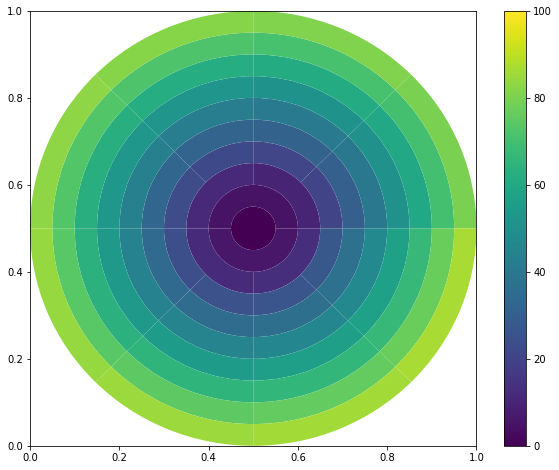

In [30]:
draw_wedges(W, figsize=(10,8), alpha=1.0)

In [31]:
KRES = select_rphi_sectors(dst, DT, E, Q, W, verbose = False)

### Time 

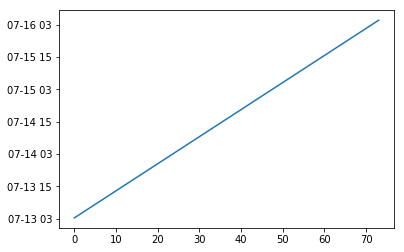

In [32]:
plt.plot(krTimes.timeStamps)

### Event distribution

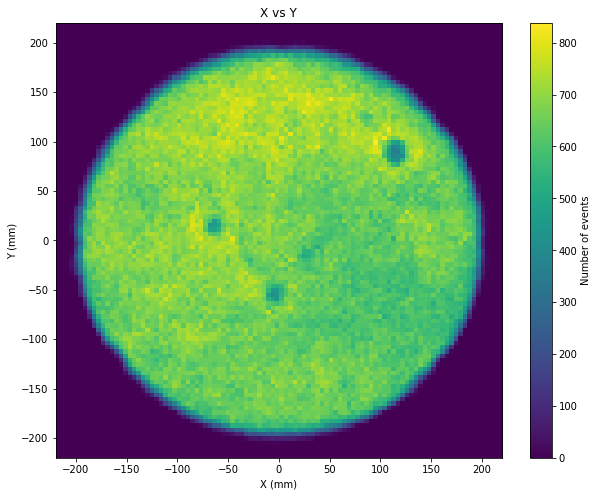

In [33]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

### Events per sector

number of events in sector = 213108.0


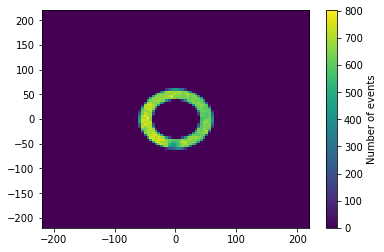

In [34]:
plot_sector(KRES, krNbins.X, krNbins.Y, krRanges.X,krRanges.Y, sector=2)

number of events in sector = 43747.0
number of events in sector = 126464.0
number of events in sector = 213108.0
number of events in sector = 299742.0
number of events in sector = 386972.0
number of events in sector = 477252.0
number of events in sector = 569340.0
number of events in sector = 653436.0
number of events in sector = 730688.0
number of events in sector = 575440.0


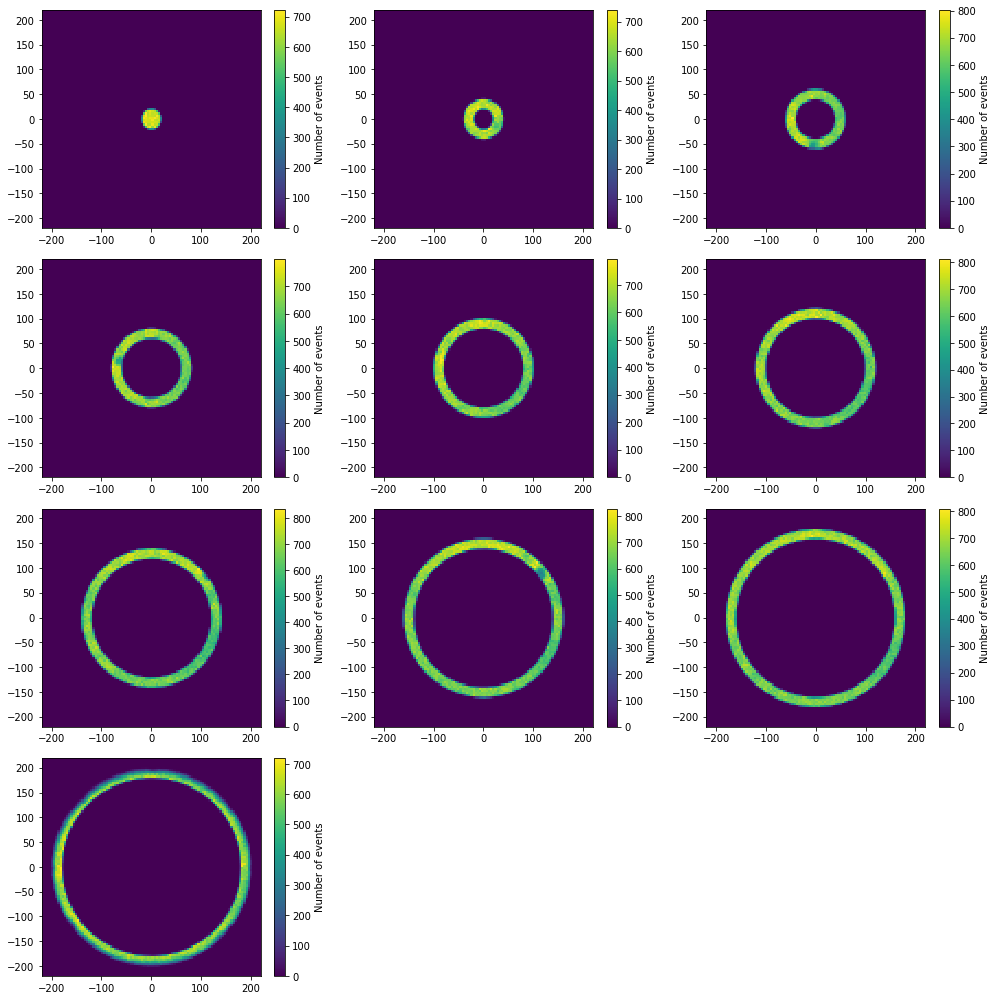

In [35]:
plot_sectors(KRES, krNbins.X, krNbins.Y, krRanges.X,krRanges.Y)

## Fits in radial sectors

### Lifetime is fitted each XT seconds in the radial sectors (0 to 9) defined.

In [36]:
XT = 5000

In [37]:
fps = fit_fcs_in_sectors(0, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)
                    

[1, 2, 4, 8, 8, 8, 8, 8, 8, 8]


wedge = 0: chi2 =     0.89 +-   0.21; e0 = 11820.64 +-  19.28; lt =  2626.66 +-  65.35;


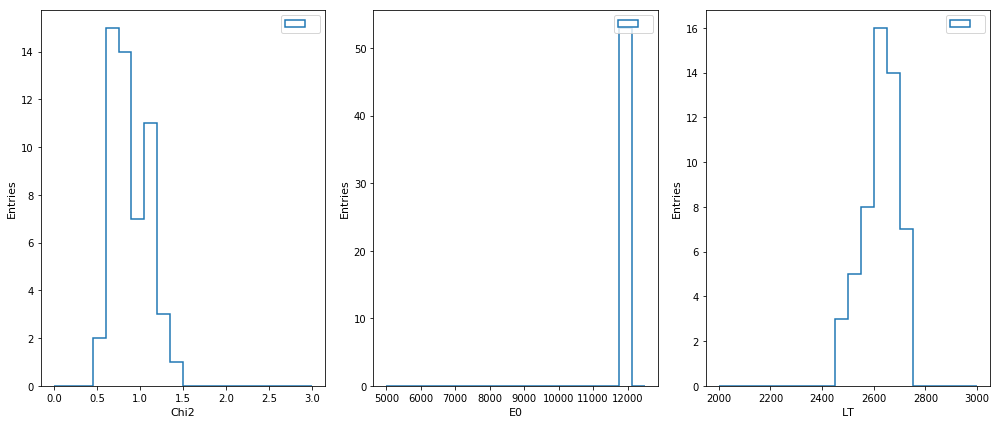

In [40]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

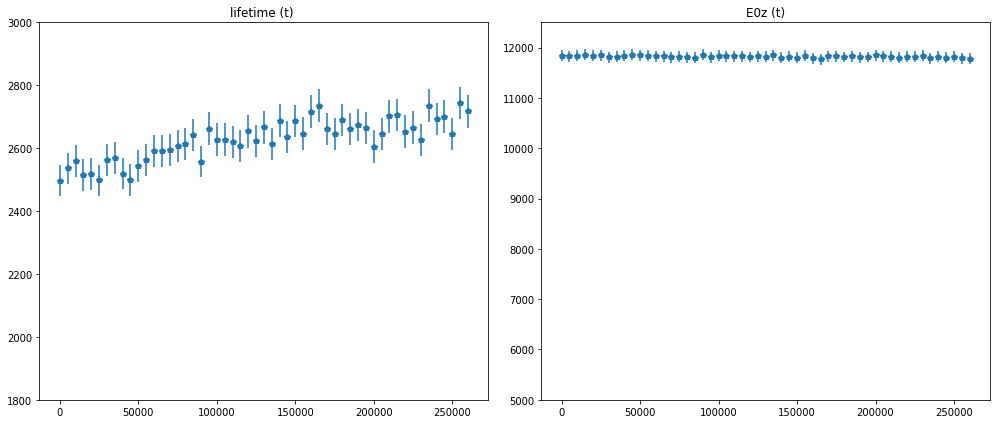

In [42]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [43]:
fps = fit_fcs_in_sectors(1, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)
 

wedge = 0: chi2 =     0.94 +-   0.19; e0 = 11754.64 +-  21.96; lt =  2636.59 +-  72.11;
wedge = 1: chi2 =     0.92 +-   0.23; e0 = 11710.14 +-  15.17; lt =  2614.65 +-  49.06;


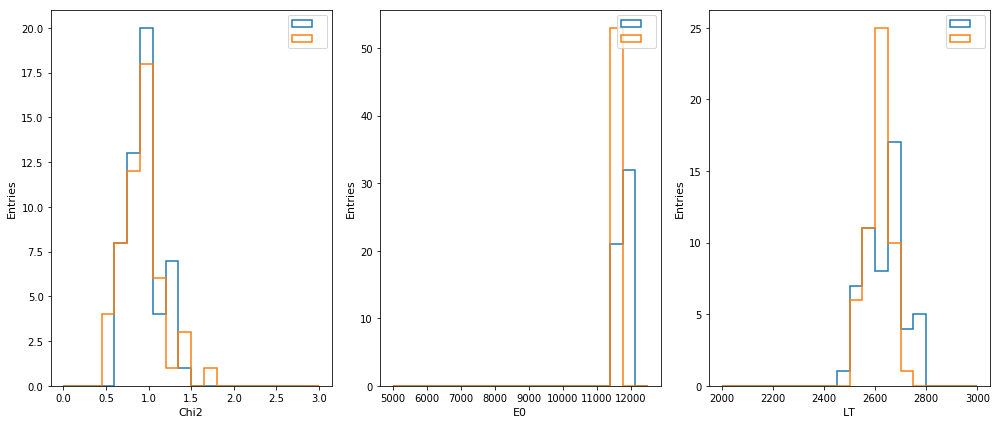

In [45]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts )

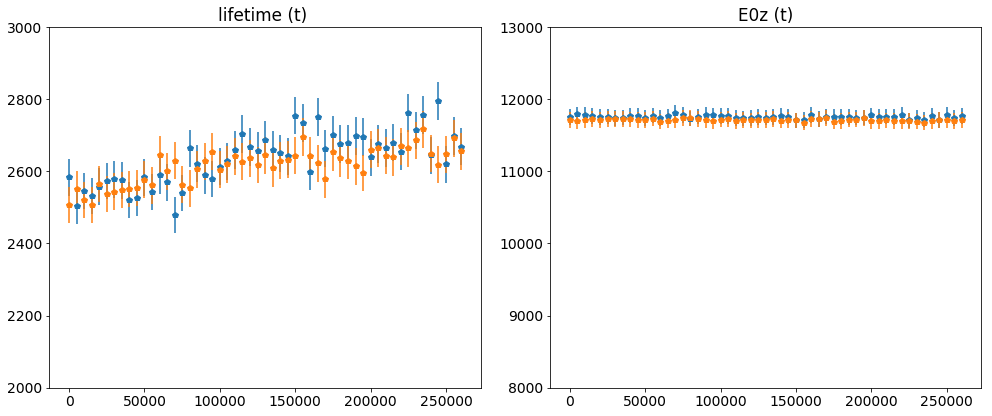

In [52]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [46]:
fps = fit_fcs_in_sectors(2, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)



wedge = 0: chi2 =     0.88 +-   0.22; e0 = 12027.52 +-  24.10; lt =  2508.95 +-  60.06;
wedge = 1: chi2 =     0.96 +-   0.26; e0 = 11671.81 +-  17.14; lt =  2560.11 +-  58.35;
wedge = 2: chi2 =     0.94 +-   0.17; e0 = 11395.68 +-  15.19; lt =  2588.81 +-  47.17;
wedge = 3: chi2 =     0.95 +-   0.22; e0 = 11685.21 +-  14.63; lt =  2530.08 +-  46.19;


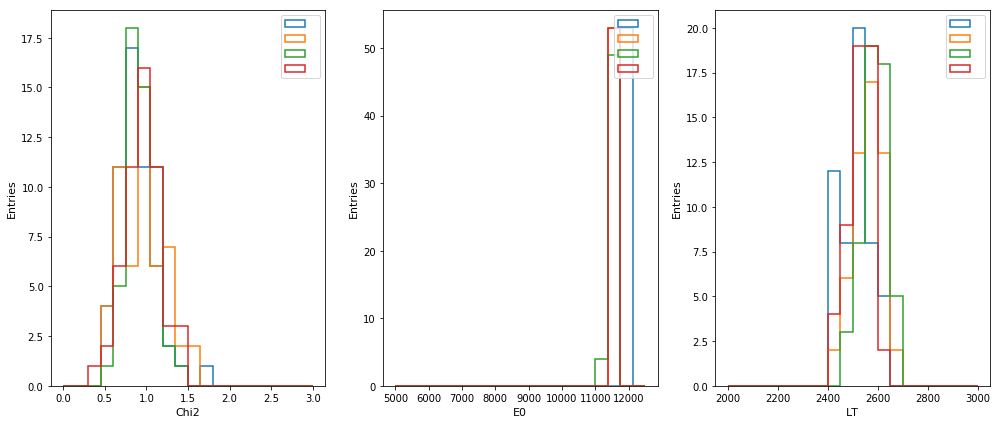

In [47]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

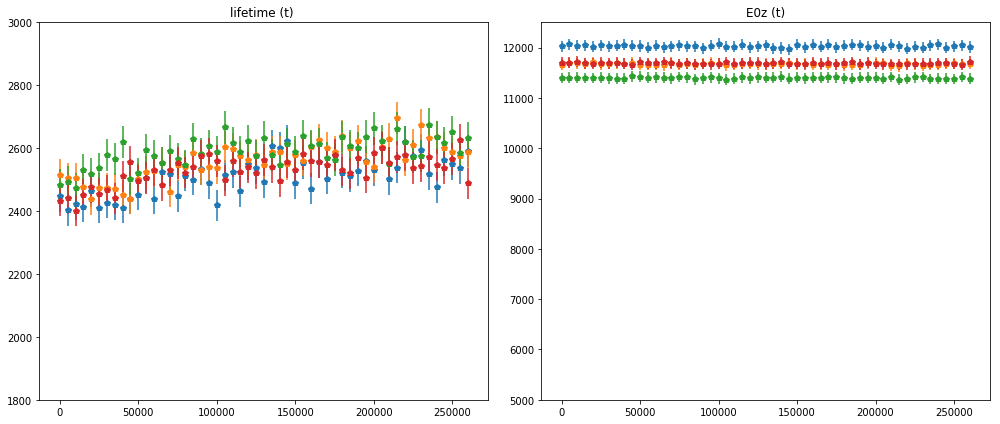

In [49]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [50]:
fps = fit_fcs_in_sectors(3, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.88 +-   0.21; e0 = 12028.27 +-  20.18; lt =  2502.18 +-  50.06;
wedge = 1: chi2 =     0.89 +-   0.20; e0 = 11873.06 +-  26.55; lt =  2513.94 +-  57.28;
wedge = 2: chi2 =     0.98 +-   0.23; e0 = 11541.17 +-  22.75; lt =  2508.55 +-  55.67;
wedge = 3: chi2 =     0.96 +-   0.20; e0 = 11350.60 +-  22.11; lt =  2605.83 +-  72.38;
wedge = 4: chi2 =     0.93 +-   0.21; e0 = 11178.64 +-  18.55; lt =  2614.92 +-  51.81;
wedge = 5: chi2 =     0.91 +-   0.21; e0 = 11093.96 +-  19.69; lt =  2368.53 +-  47.28;
wedge = 6: chi2 =     0.94 +-   0.21; e0 = 11353.96 +-  20.25; lt =  2394.93 +-  55.27;
wedge = 7: chi2 =     0.92 +-   0.17; e0 = 11665.45 +-  22.47; lt =  2519.27 +-  61.24;


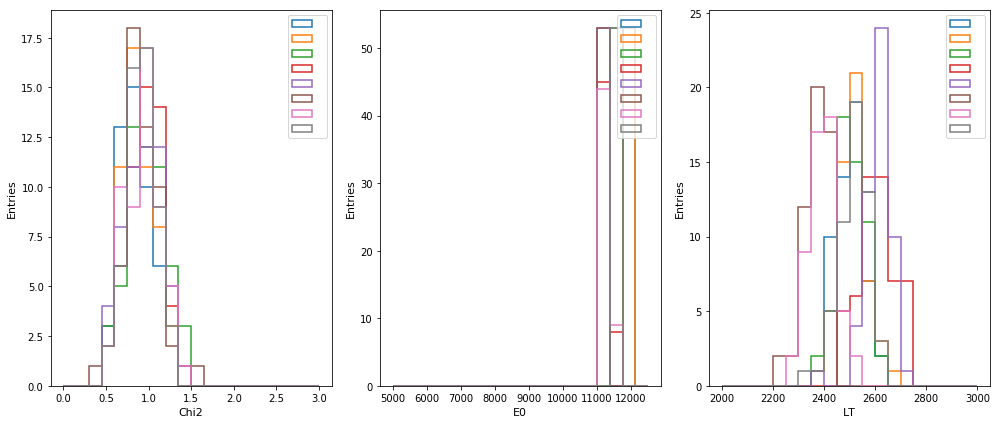

In [51]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

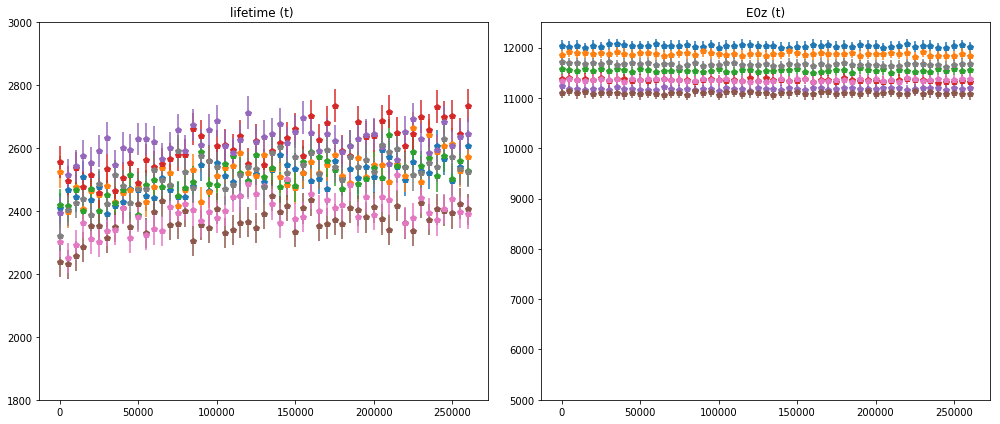

In [52]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [53]:
fps = fit_fcs_in_sectors(4, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.90 +-   0.20; e0 = 11762.45 +-  16.43; lt =  2527.94 +-  50.94;
wedge = 1: chi2 =     0.91 +-   0.17; e0 = 11646.78 +-  16.18; lt =  2500.57 +-  43.96;
wedge = 2: chi2 =     0.92 +-   0.18; e0 = 11348.64 +-  19.93; lt =  2484.63 +-  51.59;
wedge = 3: chi2 =     0.88 +-   0.21; e0 = 11030.69 +-  15.73; lt =  2597.61 +-  64.97;
wedge = 4: chi2 =     0.92 +-   0.20; e0 = 10888.69 +-  18.25; lt =  2569.23 +-  55.61;
wedge = 5: chi2 =     0.96 +-   0.22; e0 = 10818.44 +-  14.61; lt =  2258.43 +-  35.39;
wedge = 6: chi2 =     0.99 +-   0.22; e0 = 11070.74 +-  22.47; lt =  2291.83 +-  49.18;
wedge = 7: chi2 =     0.88 +-   0.26; e0 = 11382.48 +-  19.43; lt =  2495.39 +-  47.62;


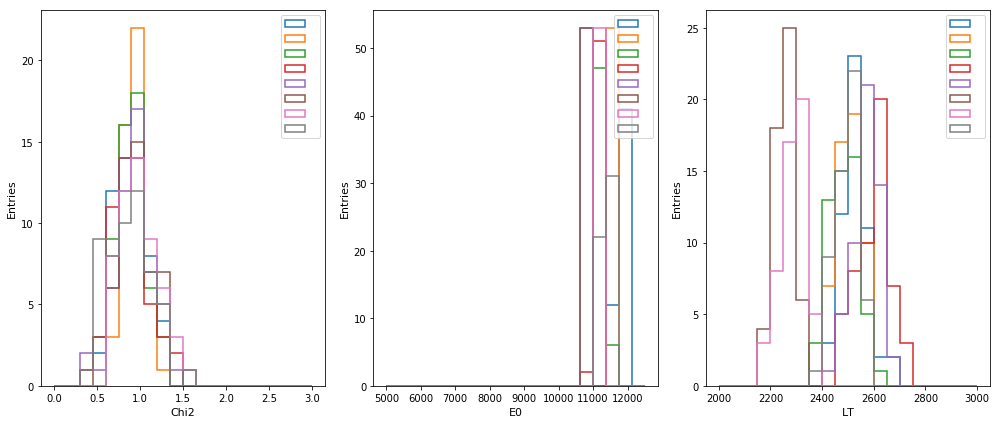

In [54]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

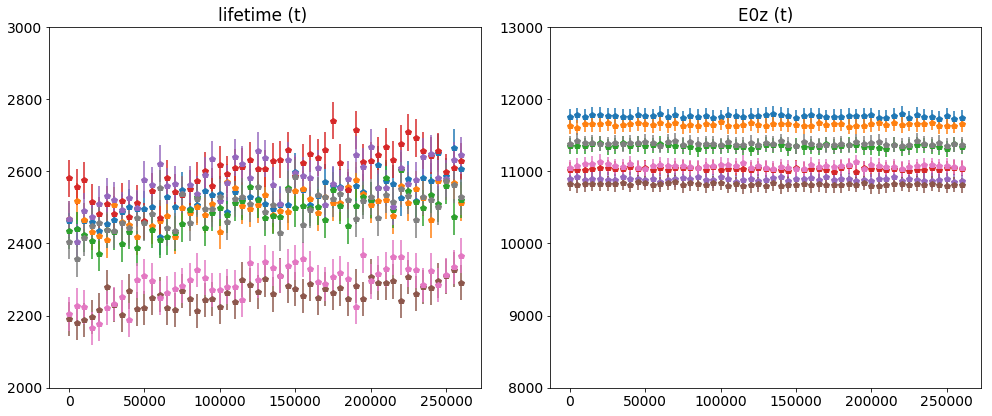

In [61]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [55]:
fps = fit_fcs_in_sectors(5, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.84 +-   0.21; e0 = 11521.36 +-  18.90; lt =  2518.28 +-  44.29;
wedge = 1: chi2 =     0.92 +-   0.20; e0 = 11519.14 +-  17.61; lt =  2456.43 +-  40.81;
wedge = 2: chi2 =     0.90 +-   0.18; e0 = 11147.10 +-  19.45; lt =  2437.86 +-  49.28;
wedge = 3: chi2 =     0.95 +-   0.22; e0 = 10757.74 +-  17.01; lt =  2559.86 +-  69.18;
wedge = 4: chi2 =     0.94 +-   0.20; e0 = 10563.28 +-  16.84; lt =  2511.51 +-  47.44;
wedge = 5: chi2 =     0.92 +-   0.20; e0 = 10501.22 +-  16.43; lt =  2174.76 +-  31.20;
wedge = 6: chi2 =     0.95 +-   0.23; e0 = 10709.07 +-  19.25; lt =  2227.34 +-  38.11;
wedge = 7: chi2 =     0.95 +-   0.19; e0 = 10989.26 +-  20.33; lt =  2489.41 +-  52.53;


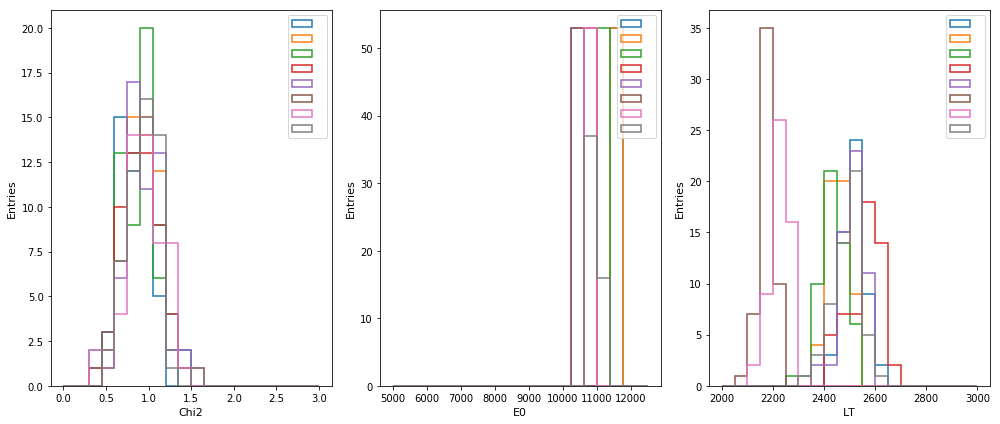

In [56]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

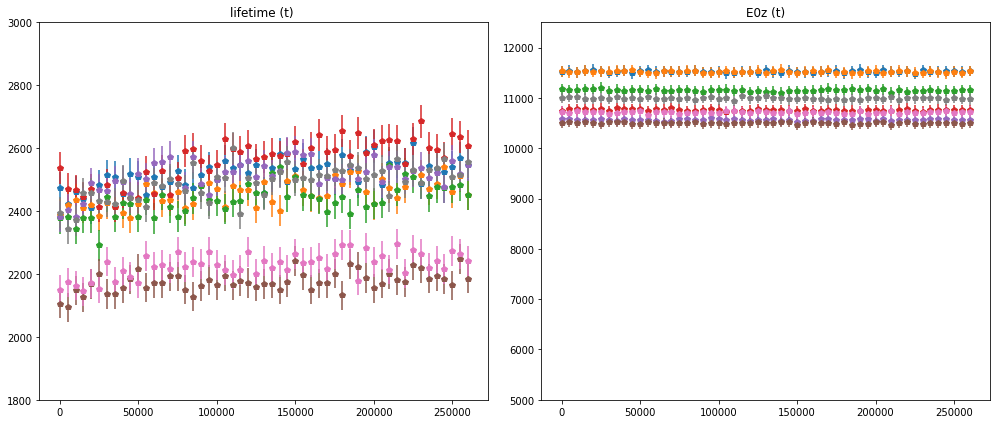

In [57]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [58]:
fps = fit_fcs_in_sectors(6, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.85 +-   0.18; e0 = 11273.90 +-  15.87; lt =  2502.32 +-  35.82;
wedge = 1: chi2 =     0.97 +-   0.24; e0 = 11308.83 +-  14.67; lt =  2393.19 +-  29.02;
wedge = 2: chi2 =     0.96 +-   0.25; e0 = 10840.09 +-  19.97; lt =  2372.27 +-  37.39;
wedge = 3: chi2 =     0.91 +-   0.21; e0 = 10409.81 +-  14.35; lt =  2530.24 +-  53.53;
wedge = 4: chi2 =     0.91 +-   0.22; e0 = 10193.93 +-  16.80; lt =  2456.31 +-  46.06;
wedge = 5: chi2 =     0.90 +-   0.20; e0 =  9998.18 +-  17.24; lt =  2123.88 +-  34.01;
wedge = 6: chi2 =     0.89 +-   0.21; e0 = 10189.10 +-  21.83; lt =  2181.76 +-  42.67;
wedge = 7: chi2 =     0.93 +-   0.19; e0 = 10610.54 +-  18.31; lt =  2459.78 +-  51.87;


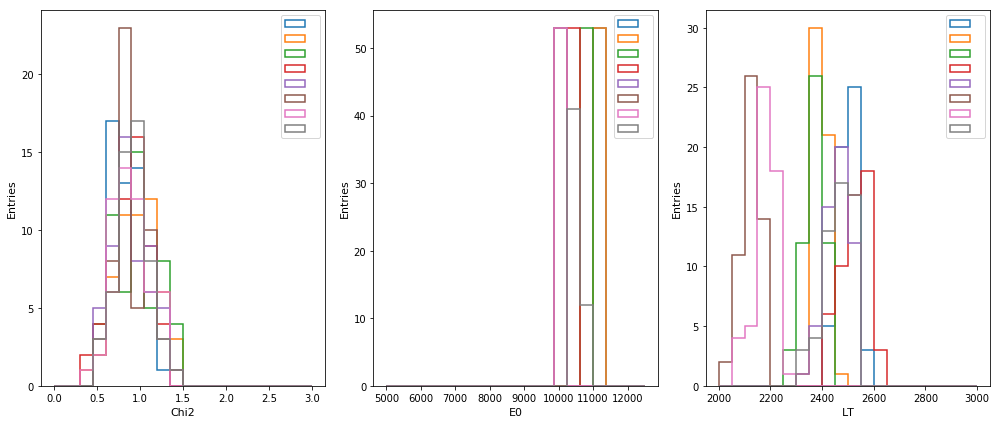

In [59]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

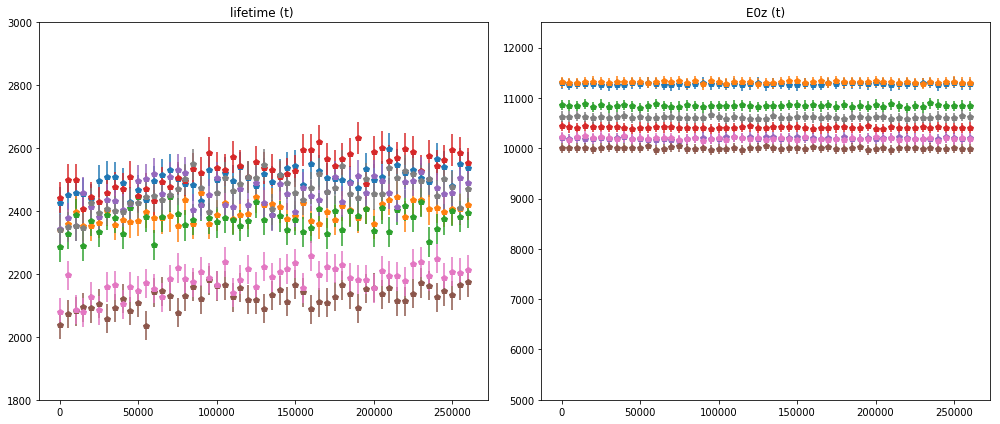

In [60]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [61]:
fps = fit_fcs_in_sectors(7, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.93 +-   0.23; e0 = 10872.58 +-  20.45; lt =  2480.53 +-  46.41;
wedge = 1: chi2 =     0.98 +-   0.17; e0 = 10867.53 +-  16.50; lt =  2361.78 +-  30.45;
wedge = 2: chi2 =     0.91 +-   0.25; e0 = 10305.83 +-  17.53; lt =  2330.21 +-  29.74;
wedge = 3: chi2 =     0.93 +-   0.27; e0 =  9920.92 +-  19.12; lt =  2493.29 +-  68.81;
wedge = 4: chi2 =     0.91 +-   0.26; e0 =  9682.30 +-  18.10; lt =  2426.35 +-  44.89;
wedge = 5: chi2 =     0.87 +-   0.21; e0 =  9322.47 +-  19.20; lt =  2039.06 +-  42.37;
wedge = 6: chi2 =     0.88 +-   0.17; e0 =  9555.45 +-  19.16; lt =  2082.59 +-  36.33;
wedge = 7: chi2 =     0.95 +-   0.18; e0 = 10143.97 +-  19.20; lt =  2436.73 +-  51.52;


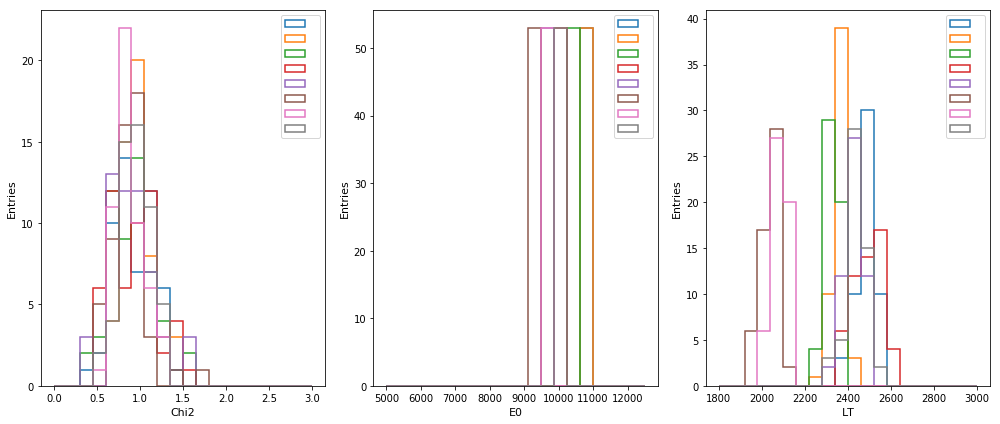

In [62]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1800, 3000))
print_fit_sectors_pars(fpts)

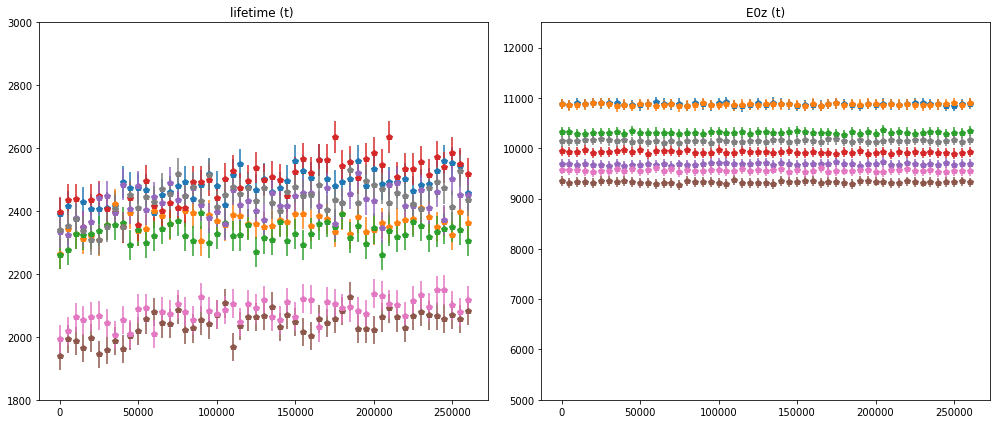

In [63]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [64]:
fps = fit_fcs_in_sectors(8, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.81 +-   0.19; e0 = 10223.24 +-  18.54; lt =  2425.73 +-  47.28;
wedge = 1: chi2 =     0.86 +-   0.19; e0 = 10212.15 +-  19.34; lt =  2296.63 +-  39.42;
wedge = 2: chi2 =     0.84 +-   0.22; e0 =  9582.91 +-  19.38; lt =  2273.14 +-  39.85;
wedge = 3: chi2 =     0.89 +-   0.20; e0 =  9215.30 +-  15.87; lt =  2430.68 +-  58.73;
wedge = 4: chi2 =     0.98 +-   0.23; e0 =  9011.38 +-  22.88; lt =  2331.22 +-  47.82;
wedge = 5: chi2 =     0.96 +-   0.21; e0 =  8482.90 +-  20.58; lt =  1955.45 +-  38.63;
wedge = 6: chi2 =     0.91 +-   0.18; e0 =  8767.70 +-  23.08; lt =  1975.40 +-  33.70;
wedge = 7: chi2 =     0.93 +-   0.24; e0 =  9496.74 +-  24.59; lt =  2323.35 +-  44.73;


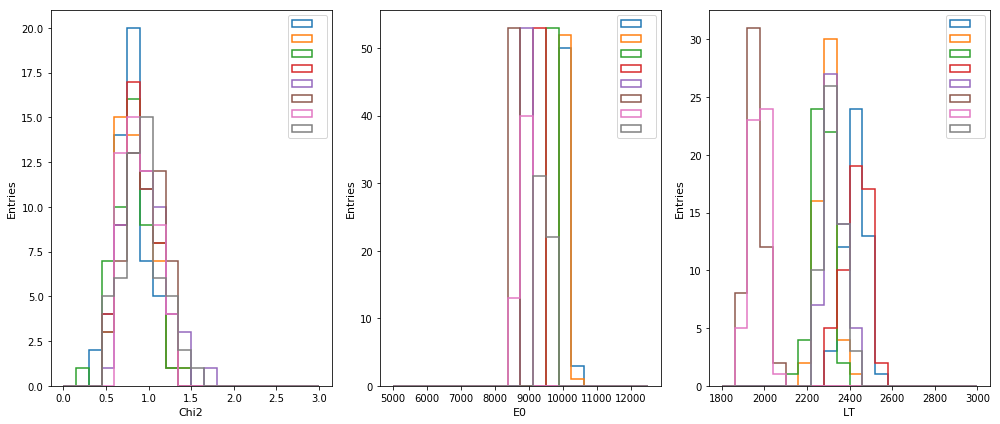

In [65]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1800, 3000))
print_fit_sectors_pars(fpts)

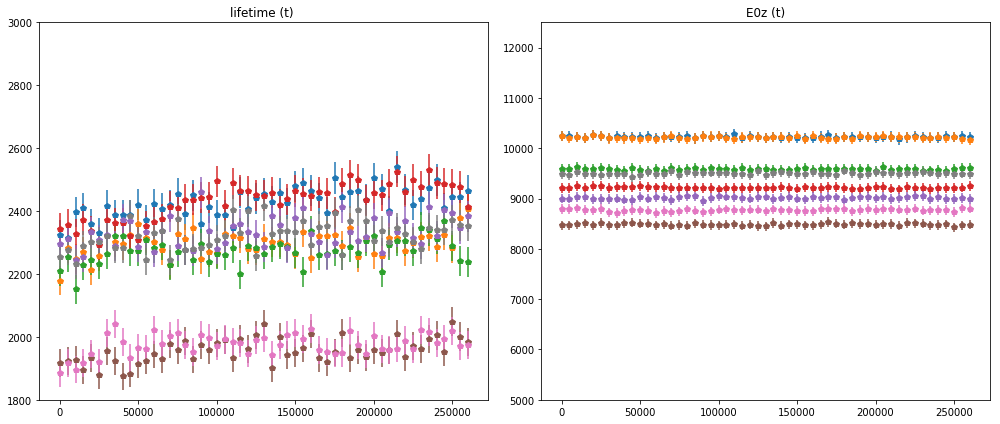

In [66]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [67]:
fps = fit_fcs_in_sectors(9, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.87 +-   0.23; e0 =  8955.99 +-  40.88; lt =  2509.94 +-  87.37;
wedge = 1: chi2 =     0.94 +-   0.25; e0 =  8852.65 +-  38.37; lt =  2540.93 +-  85.26;
wedge = 2: chi2 =     0.88 +-   0.23; e0 =  8318.90 +-  38.13; lt =  2448.38 +-  95.77;
wedge = 3: chi2 =     0.90 +-   0.21; e0 =  8045.61 +-  29.47; lt =  2449.49 +-  74.79;
wedge = 4: chi2 =     0.89 +-   0.20; e0 =  7765.08 +-  29.73; lt =  2566.13 +-  76.92;
wedge = 5: chi2 =     0.93 +-   0.23; e0 =  7198.11 +-  34.19; lt =  2337.73 +-  85.69;
wedge = 6: chi2 =     0.89 +-   0.19; e0 =  7418.15 +-  33.09; lt =  2455.33 +-  86.16;
wedge = 7: chi2 =     0.92 +-   0.24; e0 =  8203.52 +-  42.59; lt =  2709.50 +- 107.02;


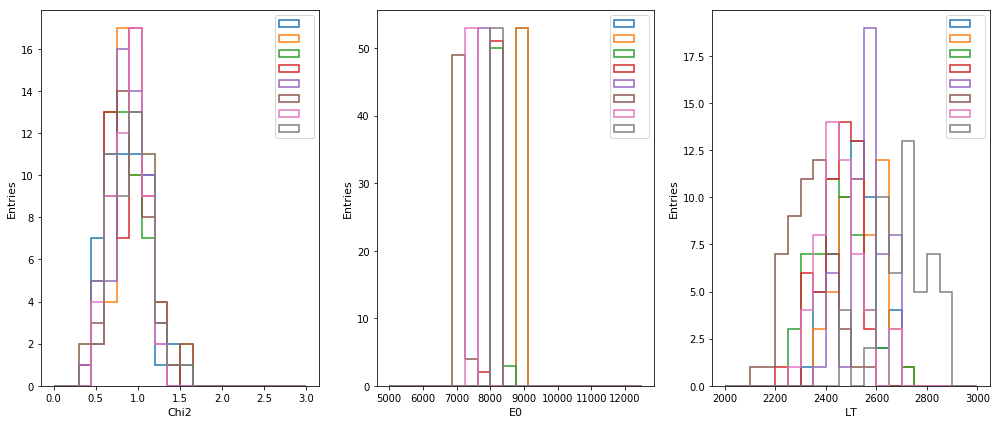

In [68]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

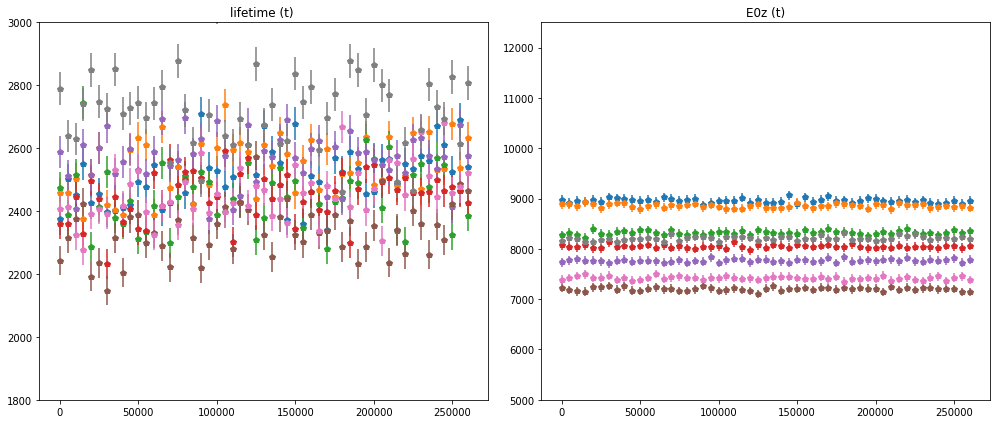

In [69]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

### Fits in sectors:
1. chi2 of fits is good.
2. E0 decreases in each sector and varies significantly with phi.
3. LT has an structure, splitting in some sectors in two peaks.

## Maps

In [72]:
fmap = fit_map(XT, DT, KRES, 
               krNbins.Z, krNbins.S2e,
               range_z     = (50,550),
               range_e     = (5000, 13000),
               range_chi2  = (0,3),
               range_lt    = (1800, 3000),
               energy      = 'S2e', 
               fit         = FitType.profile,
               verbose     = True)

Fitting sector 0
 number of wedges in sector 1
Fitting sector 1
 number of wedges in sector 2
Fitting sector 2
 number of wedges in sector 4
Fitting sector 3
 number of wedges in sector 8
Fitting sector 4
 number of wedges in sector 8
Fitting sector 5
 number of wedges in sector 8
Fitting sector 6
 number of wedges in sector 8
Fitting sector 7
 number of wedges in sector 8
Fitting sector 8
 number of wedges in sector 8
Fitting sector 9
 number of wedges in sector 8


In [158]:
ts = fmap[0][0].ts

In [159]:
ts

array([     0,   5000,  10000,  15000,  20000,  25000,  30000,  35000,
        40000,  45000,  50000,  55000,  60000,  65000,  70000,  75000,
        80000,  85000,  90000,  95000, 100000, 105000, 110000, 115000,
       120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000,
       160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000,
       200000, 205000, 210000, 215000, 220000, 225000, 230000, 235000,
       240000, 245000, 250000, 255000, 260000])

In [160]:
len(ts)

53

In [143]:
tsm = tsmap_from_fmap(fmap, verbose  = False)

In [154]:
am = amap_from_tsmap(tsm, 
                     ts = -1, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))

In [162]:
asm = relative_errors(am)

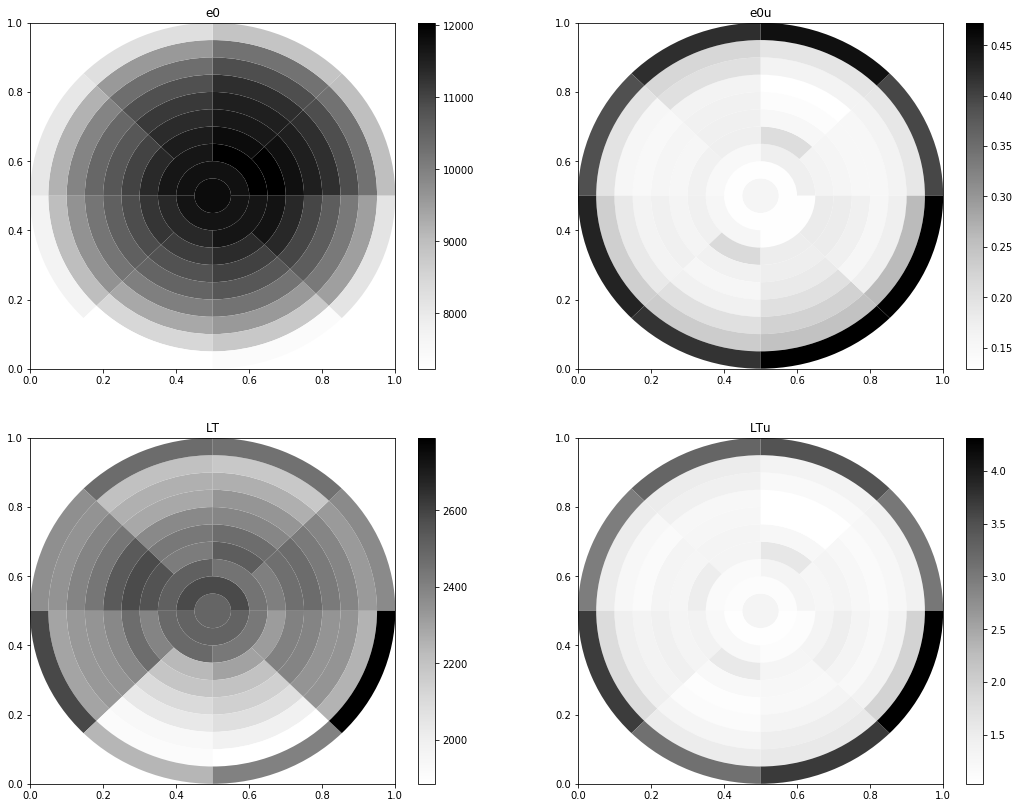

In [165]:
draw_maps(W, asm, verbose = True,
          cmap    = matplotlib.cm.Greys,
          alpha   = 1.0,  
          figsize=(18,14))

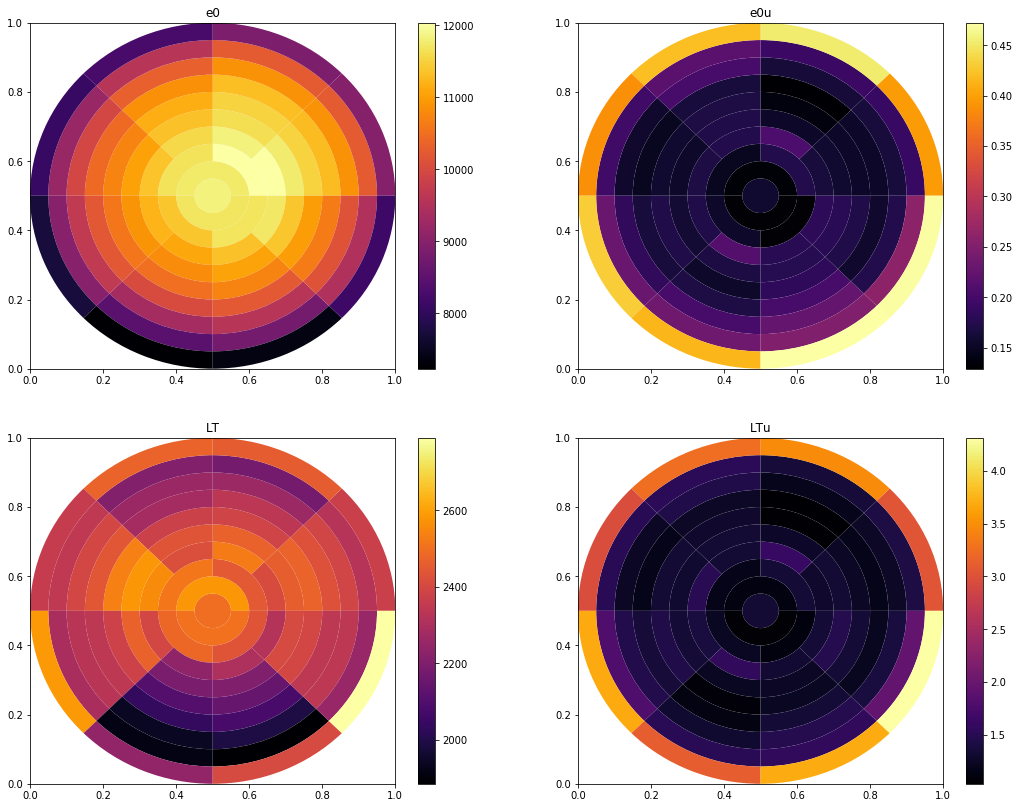

In [157]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))
asm = relative_errors(am)
draw_maps(W, asm, verbose = True,
          cmap    = matplotlib.cm.inferno,
          alpha   = 1.0,  
          figsize=(18,14))

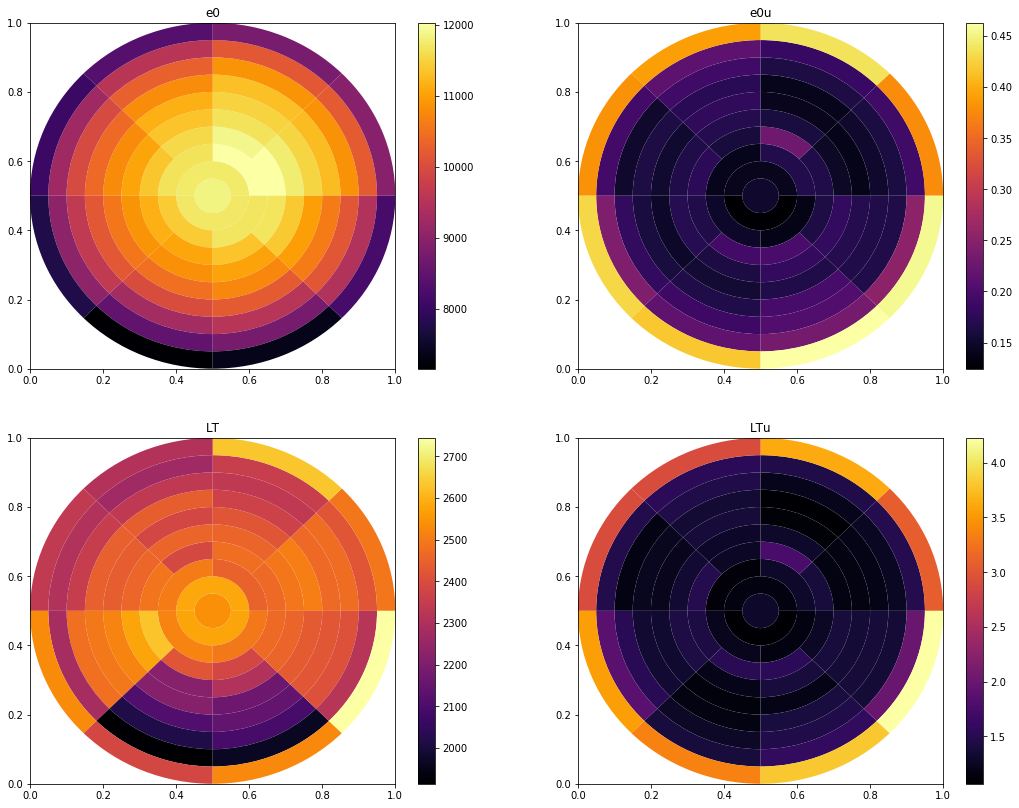

In [166]:
am = amap_from_tsmap(tsm, 
                     ts = 10, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))
asm = relative_errors(am)
draw_maps(W, asm, verbose = True,
          cmap    = matplotlib.cm.inferno,
          alpha   = 1.0,  
          figsize=(18,14))

In [59]:
invalid = ~valid
mask = valid

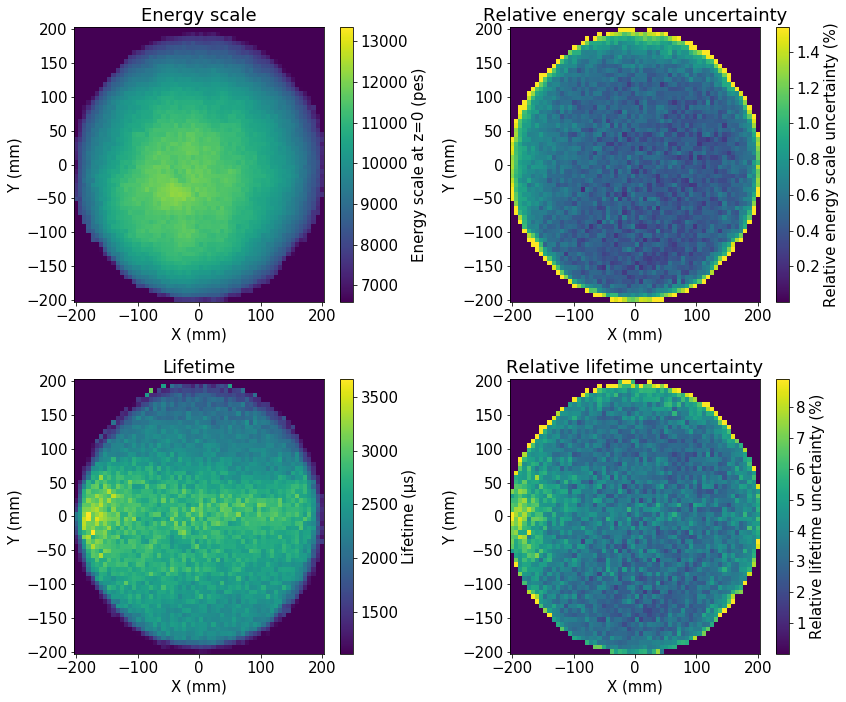

In [60]:
krp.figsize("L")
krp.display_lifetime_maps(Escale, ELT, kltl, krBins.cXY, cmap="viridis", mask=valid)
                         

(1.2341219470183695, 0.66563217860108326)

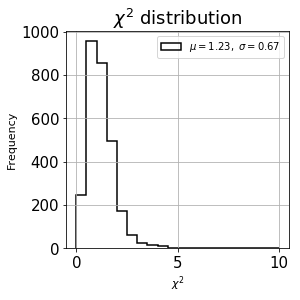

In [61]:
krp.figsize("S")
krh.h1d(Echi2[valid], bins=20, range=(0,10), xlabel="$\chi^2$", ylabel='Frequency',
        title="$\chi^2$ distribution", legend = 'upper right', figsize=(4,4))

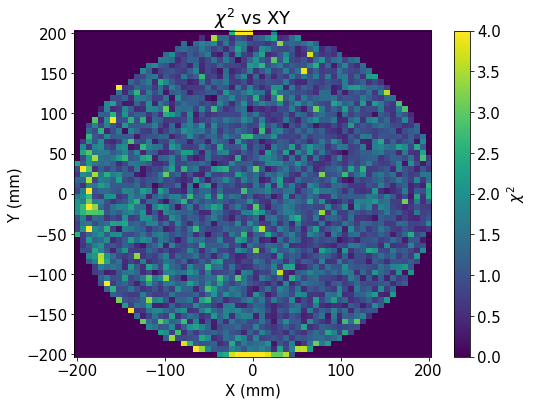

In [62]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1)
#plt.subplot(1, 1, 1)
*_, cb = display_matrix(krBins.cXY, krBins.cXY, Echi2, mask=valid,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

### Produce HDF5 output

In [72]:
nevt = nEvt.fid

In [73]:
print(map_filename)

/Users/jjgomezcadenas/Projects/ICDATA/maps/lmap_6224_0000_29999.h5


In [74]:
with tb.open_file(map_filename, "w") as correction_file:
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(krBins.cXY, krBins.cXY, Escale_corr.value, Escale_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Escale.attrs.xy_bins  = krNBins.XY
    correction_file.root.XYcorrections.Escale.attrs.xy_pitch = krBins.pXY

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Lifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(krBins.cXY, krBins.cXY, ELT_corr.value, ELT_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Lifetime.attrs.xy_bins  = krNBins.XY
    correction_file.root.XYcorrections.Lifetime.attrs.xy_pitch = krBins.pXY

